In [27]:
import numpy as np
import sympy as sp
import matplotlib
import random
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
%matplotlib inline 


Shape fcns and derivatives

In [28]:
# Shape functions and derivatives 

def Nvec(xi,eta):
    return 0.25*np.array([(1-xi)*(1-eta),(1+xi)*(1-eta),(1+xi)*(1+eta),(1-xi)*(1+eta)])

def dNvecdxi(xi,eta):
    return 0.25*np.array([[(-1)*(1-eta),(+1)*(1-eta),(+1)*(1+eta),(-1)*(1+eta)],\
                          [(1-xi)*(-1),(1+xi)*(-1),(1+xi)*(+1),(1-xi)*(+1)]])

Define elastic stiffness matrix

In [43]:
#define the elastic stiffness matrix
def C_elas_Voigt():
  E=206.916 # in GPa
  nu=0.29
  constv=E/((1+nu)*(1-2*nu))
  C_v=constv*np.array([[1-nu,nu,0],[nu,1-nu,0],[0,0,(1-2*nu)/2.]])
  return C_v
C_elas_Voigt()

array([[271.15238095, 110.75238095,   0.        ],
       [110.75238095, 271.15238095,   0.        ],
       [  0.        ,   0.        ,  80.2       ]])

Damage evolution function from Simo and Ju (1989)


In [30]:
#Damage evolution function from Simo adn Ju(1989)
def dam_evol(tau_sc,tau_bar):
  t0=0.02 #GPa^.5
  A=0.85
  B=2.0
  dval=1-t0*(1-A)/tau_sc-A*np.exp(B*(t0-tau_bar))
  return dval

In [31]:
E_voight1=np.array([1,-2,-3])
C_elas1=C_elas_Voigt()
temp1=np.dot(C_elas1,E_voight1)
            #print(temp)
p1phi0=np.dot(temp1,E_voight1)
print(p1phi0)

1634.5523809523809


Define Mesh

In [32]:
n_node = 8
n_elem = 5
node_X = np.array([[0.,0.],[1.,0.],[1.,1.],[0.,1.],
                   [0.27,0.25],[0.75,0.27],[0.73,0.75],[0.25,0.73]])
elements = np.array([[0,1,5,4],[1,2,6,5],[2,3,7,6],[3,0,4,7],[4,5,6,7]])


Define integration points, always 4 for this code 

In [33]:
n_ip=4 # 4 integrtion points for 4 node quads with full integration

Plot mesh

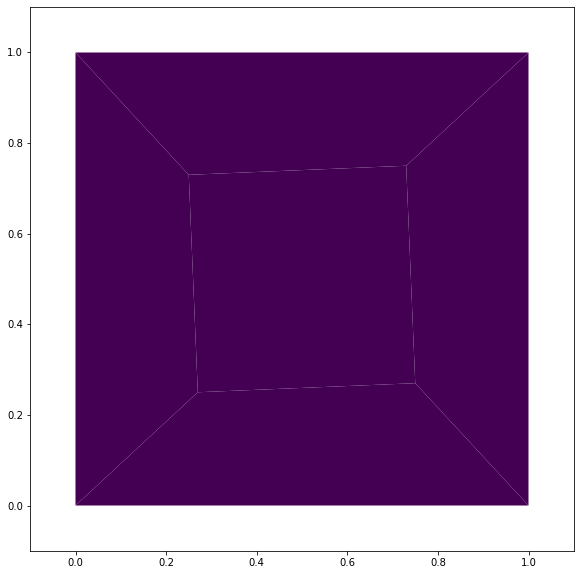

In [34]:
# plot mesh to check
## Plot the mesh 
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xlim([-0.1, 1.1])
ax.set_ylim([-0.1, 1.1])
ax.set_aspect('equal')
patches = []
#viridis = matplotlib.cm.get_cmap('viridis', 50)
colors = np.zeros((n_elem))
for i in range(n_elem):
    n1 = elements[i,0]
    n2 = elements[i,1]
    n3 = elements[i,2]
    n4 = elements[i,3]
    polygon = Polygon([node_X[n1],node_X[n2],node_X[n3],node_X[n4]], closed=True)
    patches.append(polygon)
    colors[i] = 100.
p = PatchCollection(patches)
p.set_array(colors)
ax.add_collection(p)

In [35]:
#Define the damage variables at IP
damage=np.zeros([n_elem,n_ip])
dmax=0.99

 Compute the element residual and tangent and assemble into global residual and tangent



In [56]:
# putting it inside a function
def assembleRRKK(damage):
    # assemble total residual 
    RR = np.zeros((n_node*2))
    # assemble the total tangent 
    KK = np.zeros((n_node*2,n_node*2))
    #Define damage vector
    damagevec=np.zeros([n_elem,n_ip])
    # loop over elements
    for ei in range(n_elem): 
        # initialize the residual for this element
        Re = np.zeros((8))
        # initialize the tangent for this element
        Ke = np.zeros((8,8))

        # nodes that make up this element 
        node_ei = elements[ei]
        # reference coordinates of the nodes making up this element (init to zero, fill in a loop)
        node_X_ei = np.zeros((4,2))
        # deformed coordinates of the nodes making up this element (init to zero, fill in a loop)
        node_x_ei = np.zeros((4,2))
        for ni in range(4):
            node_X_ei[ni] = node_X[node_ei[ni]]
            node_x_ei[ni] = node_x[node_ei[ni]]

        # also, do a proper integration with four integration points 
        # Loop over integration points
        # location and weight of integration points 
        IP_xi = np.array([[-1./np.sqrt(3),-1./np.sqrt(3)],[+1./np.sqrt(3),-1./np.sqrt(3)],\
                          [+1./np.sqrt(3),+1./np.sqrt(3)],[-1./np.sqrt(3),+1./np.sqrt(3)]])
        IP_wi = np.array([1.,1.,1.,1.])
        for ip in range(4):
            xi  = IP_xi[ip,0]
            eta = IP_xi[ip,1]
            wi = IP_wi[ip]
            # eval shape functions 
            Ns = Nvec(xi,eta)
            # eval the isoparametric map for the reference and deformed points corresponding to xi,eta = 0
            X = np.zeros((2))
            x = np.zeros((2))
            for ni in range(4):
                X += Ns[ni]*node_X_ei[ni]
                x += Ns[ni]*node_x_ei[ni]

            # evaluate the Jacobians, first derivative of shape functions with respect to xi space then Jacobians 
            dNsdxi = dNvecdxi(xi,eta)
            dXdxi = np.zeros((2,2))
            dxdxi = np.zeros((2,2))
            for ni in range(4):
                dXdxi += np.outer(node_X_ei[ni],dNsdxi[:,ni])
                dxdxi += np.outer(node_x_ei[ni],dNsdxi[:,ni])

            # get gradient of basis function with respect to X using inverse jacobian 
            JinvT = np.linalg.inv(dXdxi).transpose()
            dNsdX = np.dot(JinvT,dNsdxi)

            # get gradient of basis function with respect to x using inverse jacobian, the other one 
            jinvT = np.linalg.inv(dxdxi).transpose()
            dNsdx = np.dot(jinvT,dNsdxi)

            # get the deformation gradient 
            F = np.zeros((2,2))
            grad_u= np.zeros((2,2))
            for ni in range(4):
                F += np.outer(node_x_ei[ni],dNsdX[:,ni])
                ## SMALL STRAIN IS GRADIENT OF U WITH RESPECT TO DEFORMED COORDINATES
                grad_u += np.outer(node_x_ei[ni]-node_X_ei[ni],dNsdx[:,ni])
            # compute the Green lagrange tensor E
            detF = np.linalg.det(F)
            b = np.dot(F,F.transpose())
            
            #print(e)
            #e = 0.5*(np.eye(2)-np.linalg.inv(b)) # Almansi
            #e = 0.5*(F+F.transpose())-np.eye(2) #linearized strain variation
            
            ## LINEARIZED STRAIN
            e = 0.5*(grad_u + grad_u.transpose())
            #print(e)
            #Compute the elastic component of the tangent matrix
            C_elas=C_elas_Voigt()

            # Damage calulation 
            #Calculate tau
            
            # CHANGING THIS
            e_voight=np.array([e[0,0],e[1,1],2*e[0,1]])
            
            dam=damage[ei,ip]
            tau=1.0
            rundam=0
            if rundam==1:
              temp=np.dot(C_elas,e_voight)
              #print(temp)
              phi0=np.dot(e_voight,temp)
              #print(phi0)
              tau_bar=np.sqrt(2*phi0)
              
              tau=tau_bar*(1-dam)
              #print(tau)
              if dam<dmax:
                dam= dam_evol(tau,tau_bar)
              else:
                dam= dmax
              #limit the damage to dmax=0.99
              if dam<0:
               dam= 0.0
              print(dam)
              
            ## THE STRESS IS DIRECTLY COMPUTED FROM C_ELASTIC
            # changed to np.dot
            sigma_voight=(1-dam)*np.dot(C_elas,e_voight)
            sigma=np.array([[sigma_voight[0],sigma_voight[2]],[sigma_voight[2],sigma_voight[1]]])
            
            damagevec[ei,ip]=dam

            # compute the variation of the symmetric velocity gradient by moving one node and one component
            # of that node at a time, except if the node is on the boundary in which case no variation is allowed
            for ni in range(4):
                for ci in range(2):
                    deltav = np.zeros((2))
                    # note, no worries about the boundary because we will get rid of the corresponding rows
                    # of the residual because they wont be zero 
                    deltav[ci] = 1 #0.01
                    gradx_v = np.outer(deltav,dNsdx[:,ni])
                    deltad = 0.5*(gradx_v + gradx_v.transpose())
                    Re[ni*2+ci] += wi*np.linalg.det(dxdxi)*np.tensordot(sigma,deltad)

                    # ASSEMBLE INTO GLOBAL RESIDUAL (I didn't ask for this)
                    RR[node_ei[ni]*2+ci] += wi*np.linalg.det(dxdxi)*np.tensordot(sigma,deltad)
                    
                    ## 2 more for loops for the increment Delta u
                    for nj in range(4):
                        for cj in range(2):
                            Deltau = np.zeros((2))
                            Deltau[cj]=1
                            gradx_Du = np.outer(Deltau,dNsdx[:,nj])
                            Deltaeps = 0.5*(gradx_Du + gradx_Du.transpose())
                            
                            ## ELEMENT TANGENT
                            # Initial stress component (also called geometric component) is 
                            # sigma: (gradDeltau^T gradv)
                            Kgeom = np.tensordot(sigma,np.dot(gradx_Du.transpose(),gradx_v))
                            # Material component, need to put things in voigt notation for easy computation
                            deltad_voigt = np.array([deltad[0,0],deltad[1,1],2*deltad[0,1]])
                            
                            Deltaeps_voigt = np.array([Deltaeps[0,0],Deltaeps[1,1],2*Deltaeps[0,1]])
                            
                            sigsig_voigt=np.array([[sigma[0,0]*sigma[0,0],sigma[0,0]*sigma[1,1], sigma[0,0]*sigma[0,1]],\
                                                   [sigma[0,0]*sigma[1,1],sigma[1,1]*sigma[1,1], sigma[1,1]*sigma[0,1]],\
                                                   [sigma[0,0]*sigma[0,1],sigma[1,1]*sigma[0,1], sigma[0,1]*sigma[0,1]]])
                            
                            D = (1-dam)*C_elas-dam/tau*sigsig_voigt
                            #print(D)
                            Kmat = np.dot(Deltaeps_voigt,np.dot(D,deltad_voigt))
                            
                            # add to the corresponding entry in Ke and dont forget other parts of integral
                            Ke[ni*2+ci,nj*2+cj] += wi*np.linalg.det(dxdxi)*(Kgeom+Kmat)
                            # assemble into global 
                            KK[node_ei[ni]*2+ci,node_ei[nj]*2+cj] += wi*np.linalg.det(dxdxi)*(Kgeom+Kmat)
                            
    return RR,KK,damagevec
                            
        

Define the EBC

In [57]:
# apply the deformation to all the boundary nodes in the mesh, for the rest just keep original coords
node_x = np.zeros(node_X.shape)
bc_deactivate=[]
for i in range(n_node):
    X = node_X[i]
    # first initialize with the same as original
    node_x[i] = X
    # but then apply boundary conditions
    if X[0]==0.0:
      if X[1]==0.0:  #left bottom -pin node
        node_x[i,0] = X[0]
        node_x[i,1] = X[1]
        bc_deactivate.append(2*i)
        bc_deactivate.append(2*i+1)
      else:  #left surface nodes- pin only X direction
        node_x[i,0] = X[0]
        bc_deactivate.append(2*i)
    elif X[0]==1.0: #right
      if X[1]==0.0:  #right bottom -pin Y, move X
        node_x[i,0] = 1.01
        node_x[i,1] = X[1]
        bc_deactivate.append(2*i)
        bc_deactivate.append(2*i+1)
      else:
        node_x[i,0] = 1.01 #only move X
        bc_deactivate.append(2*i)
    #if X[1]>0.9999: 
    #    node_x[i,1] = 0.98
    #    bc_deactivate.append(2*i+1)
bc_deactivate=np.flip(np.unique(bc_deactivate))
print(bc_deactivate)
print(node_x)

[6 4 3 2 1 0]
[[0.   0.  ]
 [1.01 0.  ]
 [1.01 1.  ]
 [0.   1.  ]
 [0.27 0.25]
 [0.75 0.27]
 [0.73 0.75]
 [0.25 0.73]]


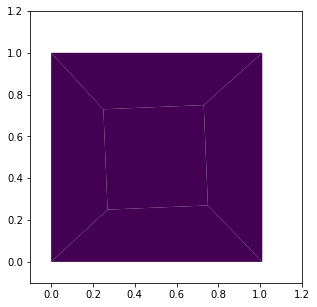

In [58]:
# plot mesh to check bc
## Plot the mesh 
fig, ax = plt.subplots(figsize=(5,5))
ax.set_xlim([-0.1, 1.2])
ax.set_ylim([-0.1, 1.2])
ax.set_aspect('equal')
patches = []
#viridis = matplotlib.cm.get_cmap('viridis', 50)
colors = np.zeros((n_elem))
for i in range(n_elem):
    n1 = elements[i,0]
    n2 = elements[i,1]
    n3 = elements[i,2]
    n4 = elements[i,3]
    polygon = Polygon([node_x[n1],node_x[n2],node_x[n3],node_x[n4]], closed=True)
    patches.append(polygon)
    colors[i] = 100.
p = PatchCollection(patches)
p.set_array(colors)
ax.add_collection(p)

In [59]:
## Newton Raphson 
res = 1
iter = 0
tol = 1e-5
itermax = 100
#Define time loop for loading
damage=np.zeros([n_elem,n_ip])



while res>tol and iter<itermax:
    RR,KK,damage_new = assembleRRKK(damage);
    # for the increment not all of the KK is needed
    #print(RR)
    RRdof = np.delete(RR,bc_deactivate,axis=0)
    KKdof = np.delete(KK,bc_deactivate,axis=1)
    KKdof = np.delete(KKdof,bc_deactivate,axis=0)
    #print(bc_deactivate)
    #print(RRdof)

    #print(KKdof.shape)
    res = np.linalg.norm(RRdof)
    #print(KKdof)
    incr_u = -np.linalg.solve(KKdof,RRdof)
    #print(incr_u.shape)
    #print(len(node_x))

    # and only some of the nodes need this increment
    ctr=0
    for jj in range(n_node):
      temp1=2*jj  #the x disp
      temp2=2*jj+1 #the y disp
      if temp1 in bc_deactivate:
        ;
      else:
        node_x[jj,0] += incr_u[ctr]
        ctr+=1;        
      if temp2 in bc_deactivate:
        ;
      else:
        node_x[jj,1] += incr_u[ctr]
        ctr+=1;        
    #print('ctr %i'%ctr)
    iter +=1
    print('iter %i'%iter)
    print(res)
    #print(incr_u)
    #print(node_x)
    #print(damage)
    #print(RRdof)
    #print(RR)




iter 1
6.304532970480475
iter 2
0.203026782408587
iter 3
0.003726568313348745
iter 4
6.83138998544196e-05
iter 5
1.2755024052512641e-06


In [40]:
print(node_X)
print(node_x)


[[0.   0.  ]
 [1.   0.  ]
 [1.   1.  ]
 [0.   1.  ]
 [0.27 0.25]
 [0.75 0.27]
 [0.73 0.75]
 [0.25 0.73]]
[[0.         0.        ]
 [1.01       0.        ]
 [1.01       0.99405823]
 [0.         1.00594177]
 [0.27276617 0.25049618]
 [0.75754765 0.26888169]
 [0.73736639 0.74776444]
 [0.25254698 0.73185105]]


In [41]:
damage_new

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

[ 2.6672204  -0.12812187 -0.        ] 0.0
[ 2.6101826  -0.53988233 -0.        ] 0.0
[ 2.65951103  0.12744434 -0.        ] 0.0
[ 2.72256414  0.53208638 -0.        ] 0.0
[ 2.66694700e+00  7.72490158e-06 -0.00000000e+00] 0.0


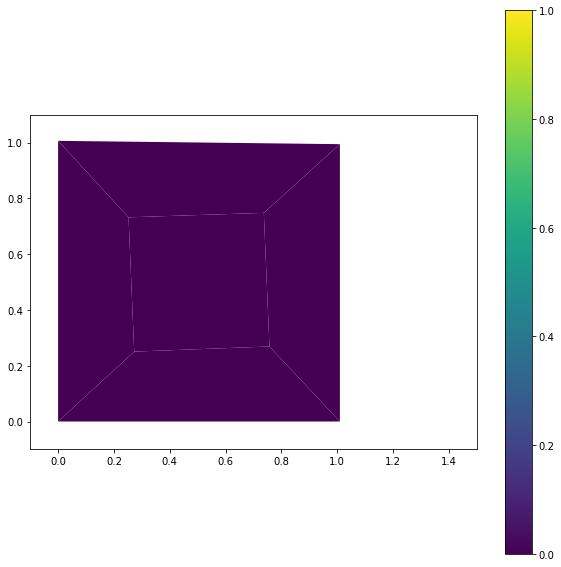

In [42]:
## Plot the deformed mesh, evaluate the stress at the center
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xlim([-0.1, 1.5])
ax.set_ylim([-0.1, 1.1])
ax.set_aspect('equal')
patches = []
#viridis = matplotlib.cm.get_cmap('viridis', 50)
colors = np.zeros((n_elem))
for i in range(n_elem):
    n1 = elements[i,0]
    n2 = elements[i,1]
    n3 = elements[i,2]
    n4 = elements[i,3]
    polygon = Polygon([node_x[n1],node_x[n2],node_x[n3],node_x[n4]], closed=True)
    patches.append(polygon)
    # compute stress at center 
    xi  = 0
    eta = 0
    # eval shape functions 
    Ns = Nvec(xi,eta)
    # eval the isoparametric map 
    X = Ns[0]*node_X[n1]+Ns[1]*node_X[n2]+Ns[2]*node_X[n3]+Ns[3]*node_X[n4]
    X = Ns[0]*node_x[n1]+Ns[1]*node_x[n2]+Ns[2]*node_x[n3]+Ns[3]*node_x[n4]
    # evaluate the Jacobians, first derivative of shape functions with respect to xi space then Jacobians 
    dNsdxi = dNvecdxi(xi,eta)
    dXdxi = np.outer(node_X[n1],dNsdxi[:,0])+np.outer(node_X[n2],dNsdxi[:,1])\
            +np.outer(node_X[n3],dNsdxi[:,2])+np.outer(node_X[n4],dNsdxi[:,3])
    dxdxi = np.outer(node_x[n1],dNsdxi[:,0])+np.outer(node_x[n2],dNsdxi[:,1])\
            +np.outer(node_x[n3],dNsdxi[:,2])+np.outer(node_x[n4],dNsdxi[:,3])
    # get gradient of basis function with respect to X using inverse jacobian 
    JinvT = np.linalg.inv(dXdxi).transpose()
    dNsdX = np.dot(JinvT,dNsdxi)
    # get gradient of basis function with respect to x using inverse jacobian, the other one 
    jinvT = np.linalg.inv(dxdxi).transpose()
    dNsdx = np.dot(jinvT,dNsdxi)
    # get the deformation gradient 
    F = np.outer(node_x[n1],dNsdX[:,0])+np.outer(node_x[n2],dNsdX[:,1])\
        +np.outer(node_x[n3],dNsdX[:,2])+np.outer(node_x[n4],dNsdX[:,3])
    detF = np.linalg.det(F)
    b = np.dot(F,F.transpose())
    e = 0.5*(np.eye(len(b))-np.linalg.inv(b))
    E_voight=np.array([e[0,0],e[1,1],e[0,1]])
    dam = damage_new[i,1]
    sigma_voight=(1-dam)*C_elas_Voigt()*E_voight
    print(sigma_voight[0],dam)
    colors[i] = dam
p = PatchCollection(patches)
p.set_array(colors)
ax.add_collection(p)
p.set_clim([0, 1])
plt.colorbar(p,ax=ax)